In [1]:
try:
    output_filepath
except:
    output_filepath = 's3://workspaces-clarity-mgmt-pro/jaime.oliver/misc/social_capital/data/processed/'
    input_filepath = 's3://workspaces-clarity-mgmt-pro/jaime.oliver/misc/social_capital/data/raw/'

In [2]:
import pandas as pd
import numpy as np
import os
from utils import data_loader
import seaborn as sns
import matplotlib.pyplot as plt

from linearmodels.iv import IV2SLS, IVGMM
from linearmodels.iv.results import compare

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from arellano_bond import PanelLaggedDep

In [3]:
reduced_terms_list, df_model = data_loader(output_filepath)

Text(0, 0.5, 'cumulative explained variance')

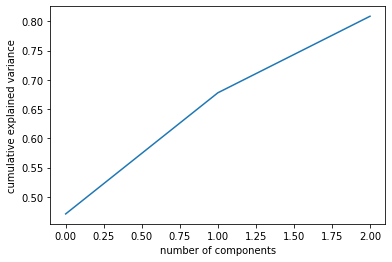

In [4]:
n = 3

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=n))]
        )

df_model[[f'pca_{i}' for i in range(n)]] = pipe.fit_transform(df_model[reduced_terms_list])

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=n))]
        )
pipe.fit(df_model[reduced_terms_list])

plt.plot(np.cumsum(pipe['reduce_dims'].explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

## Anderson Hsiao / Arellano bond estimates
We estimate the model in differences
$$\Delta\log GDP_t = \beta\Delta PCA + \Delta\epsilon$$
As instruments we use (double) lagged values of  $\log GDP$, which are:
- Exogenous (only )

Best python implementation so far: https://gist.github.com/toobaz/6d01be09bbd56de7038fe8ff26780138

In [5]:
df_index = df_model.set_index(['country', 'year'])
model = PanelLaggedDep(endog = df_index['log_gdp'],
                       exogs = df_index[[f'pca_{i}' for i in range(3)]], 
                       #exogs = df_index[[reduced_terms_list[0]]], 
                       lags=1, 
                       iv_max_lags=2,
                       systemGMM = False)
results = model.fit()
results.summary

/repos/social_capital_in_trade_networks/notebooks/arellano_bond.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dropped['CLUSTER_VAR'] = dropped.index.get_level_values(0)


<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:               Dlog_gdp   R-squared:                     -0.3059
Estimator:                     IV-GMM   Adj. R-squared:                -0.3075
No. Observations:                3315   F-statistic:                    539.35
Date:                Wed, Dec 15 2021   P-value (F-stat)                0.0000
Time:                        10:23:27   Distribution:                  chi2(4)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Dpca_0        -0.0433     0.0111    -3.9139     0.0001     -0.0650     -0.0216
Dpca_1        -0.0753     0.0662    -1.1371     0.2555     -0.2051      0.0545
Dpca_2         0.0719     0.0813     0.8838     0.3768     -0.0875      0.2312
L1Dlog_gdp     0.9742     0.0443     21.972     0.0000      0.8873      1.0611
==============================================================================

Endogenous: L1Dlog_gdp
Instruments: IVL_2, IVL_3
GMM Covariance
Debiased: False
Robust (Heteroskedastic)
"""

In [6]:
model = IV2SLS(df_model.delta_log_gdp, df_model[[f'pca_{i}' for i in range(n)] + ['constant']], df_model.lag_log_gdp, df_model.lag_log2_gdp)
results = model.fit()
results.summary

/home/ubuntu/.local/lib/python3.7/site-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:          delta_log_gdp   R-squared:                      0.0215
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0205
No. Observations:                3672   F-statistic:                    24.926
Date:                Wed, Dec 15 2021   P-value (F-stat)                0.0001
Time:                        10:23:28   Distribution:                  chi2(4)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                              
===============================================================================
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
pca_0           0.0104     0.0024     4.3498     0.0000      0.0057      0.0150
pca_1          -0.0016     0.0017    -0.9718     0.3312     -0.0048      0.0016
pca_2           0.0047     0.0033     1.4448     0.1485     -0.0017      0.0112
constant        0.2246     0.0426     5.2739     0.0000      0.1411      0.3081
lag_log_gdp    -0.0093     0.0024    -3.8218     0.0001     -0.0141     -0.0045
===============================================================================

Endogenous: lag_log_gdp
Instruments: lag_log2_gdp
Robust Covariance (Heteroskedastic)
Debiased: False
"""

In [7]:
df_radar = pd.DataFrame(pipe['reduce_dims'].components_, columns = reduced_terms_list)
df_radar.loc[:,'coefs'] = pd.Series(results.params[[f'Dpca_{i}' for i in range(n)]].values)
df_radar['pvalues'] = pd.Series(results.pvalues[[f'Dpca_{i}' for i in range(n)]].values)

labels = reduced_terms_list.copy()
stats_vector = pipe['reduce_dims'].components_[0]

angles=np.linspace(0, 2*np.pi, len(reduced_terms_list), endpoint=False)
circle_angles = np.linspace(0, 2*np.pi, 1000, endpoint=True)

fig=plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, polar=True)

for i in range(n):
    stats_vector = df_radar.loc[i,reduced_terms_list]
    c = round(df_radar.loc[i,'coefs'], 3)
    p =  round(df_radar.loc[i,'pvalues'], 3)
    ax.plot(np.concatenate((angles,[angles[0]])), np.concatenate((stats_vector,[stats_vector[0]])), 
            'o-', 
            linewidth=2, 
            label = f'effect: {c} (p: {p})'
    )
    ax.fill(angles, stats_vector, alpha=0.25)
    ax.plot(circle_angles, np.zeros_like(circle_angles), 'k--')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_thetagrids(angles * 180/np.pi, labels)
ax.grid(True)

KeyError: "None of [Index(['Dpca_0', 'Dpca_1', 'Dpca_2'], dtype='object')] are in the [index]"